In [15]:
import numpy as np
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset
from ssapp.data.Metrics import relRMSE
from ssapp.Utils import FigureSaver
from torch.utils.data.dataloader import DataLoader
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,Matern
!nvidia-smi
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

figSaver = FigureSaver('GaussianProcessHyperParameterTuning',default_format='png',dpi=600)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
train_dataset = load_serialized_dataset('CircularHornDataset1_Train')
val_dataset = load_serialized_dataset('CircularHornDataset1_Val')

train_dataloader = DataLoader(train_dataset,batch_size=len(train_dataset),shuffle=True,num_workers=4)
val_dataloader = DataLoader(val_dataset,batch_size=len(val_dataset),shuffle=True,num_workers=4)

train_params, train_fields = next(iter(train_dataloader))
train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))

print(type(train_fields.float()))

kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")

std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

def score(model,x,y):
    pred = model.predict(x)
    return relRMSE(y.reshape(len(y),-1),pred.reshape(len(pred),-1))



<class 'torch.Tensor'>


In [10]:
length_scale_sweep = np.linspace(0.1,0.75,20)

train_loss = []
val_loss = []

for length_scale in length_scale_sweep:
    kernel = ConstantKernel(10, constant_value_bounds="fixed") * RBF(length_scale, length_scale_bounds="fixed")

    std_gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])
    std_gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    train_loss.append(score(std_gp,train_params,train_fields))
    val_loss.append(score(std_gp,val_params,val_fields))



In [12]:
from matplotlib.colors import LogNorm

train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))

print(train_fields.shape)

dims = (10,10)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
const_scales = np.logspace(0, 2, num=dims[0], base=10)
RBF_scales = np.logspace(-2,  0, num=dims[1], base=10)
const_scales, RBF_scales = np.meshgrid(const_scales, RBF_scales)


score_grid = np.array([])

for const_scale,RBF_scale in zip(const_scales.flatten(),RBF_scales.flatten()):

    
    kernel = ConstantKernel(const_scale, constant_value_bounds="fixed") * RBF(RBF_scale,length_scale_bounds="fixed")
    gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Const:{const_scale}, Length Scale: {RBF_scale}, Score: {iter_score}')

score_grid = score_grid.reshape(dims)

torch.Size([2800, 361, 3, 4])
Const:1.0, Length Scale: 0.01, Score: 2.707927963244989
Const:1.6681005372000588, Length Scale: 0.01, Score: 2.7079279631748725
Const:2.7825594022071245, Length Scale: 0.01, Score: 2.7079279631328363
Const:4.641588833612778, Length Scale: 0.01, Score: 2.7079279631076374
Const:7.742636826811269, Length Scale: 0.01, Score: 2.7079279630925335
Const:12.91549665014884, Length Scale: 0.01, Score: 2.7079279630834767
Const:21.544346900318832, Length Scale: 0.01, Score: 2.707927963078048
Const:35.93813663804626, Length Scale: 0.01, Score: 2.707927963074794
Const:59.94842503189409, Length Scale: 0.01, Score: 2.7079279630728426
Const:100.0, Length Scale: 0.01, Score: 2.707927963071672
Const:1.0, Length Scale: 0.016681005372000592, Score: 1.6266238018340924
Const:1.6681005372000588, Length Scale: 0.016681005372000592, Score: 1.6266238017753722
Const:2.7825594022071245, Length Scale: 0.016681005372000592, Score: 1.6266238017401708
Const:4.641588833612778, Length Scale:

0.5014051370677597


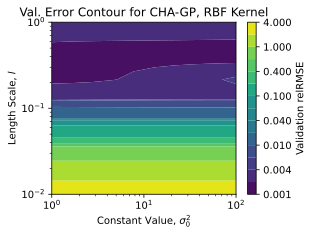

<Figure size 432x288 with 0 Axes>

In [29]:
from matplotlib import ticker, cm
from ssapp.Utils import FigureSaver



fig,ax=plt.subplots(1,1,figsize=(4.5,3.5))
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(const_scales,RBF_scales,score_grid,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2,4]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Constant Value, $\sigma_0^2$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Val. Error Contour for CHA-GP, RBF Kernel")
plt.tight_layout()
plt.show()
figSaver.save(filename = 'ValidationErrorContourPlotCHA_RBF')

In [ ]:
# RFLCT
train_dataset = load_serialized_dataset('RFCLT_Train')
val_dataset = load_serialized_dataset('RFLCT_Val')

train_params, train_fields = next(iter(train_dataloader))
val_params, val_fields = next(iter(val_dataloader))

print(train_fields.shape)

dims = (10,10)
#const_scales = np.logspace(0.001, 1, num=dims[0])
#RBF_scales = np.logspace(0.001, 1, num=dims[1])
const_scales = np.logspace(-1, 1, num=dims[0], base=10)
RBF_scales = np.logspace(-1,  1, num=dims[1], base=10)
const_scales, RBF_scales = np.meshgrid(const_scales, RBF_scales)


score_grid = np.array([])

for const_scale,RBF_scale in zip(const_scales.flatten(),RBF_scales.flatten()):

    
    kernel = ConstantKernel(const_scale, constant_value_bounds="fixed") * RBF(RBF_scale,length_scale_bounds="fixed")
    gp = Pipeline([('scaler', StandardScaler()), ('gp', GaussianProcessRegressor(kernel = kernel, normalize_y=True))])

    gp.fit(train_params,train_fields.reshape(len(train_fields),-1))

    
    iter_score = score(gp,val_params,val_fields)
    score_grid = np.append(score_grid,iter_score)
    print(f'Const:{const_scale}, Length Scale: {RBF_scale}, Score: {iter_score}')

score_grid = score_grid.reshape(dims)

In [ ]:
from matplotlib import ticker, cm
from ssapp.Utils import FigureSaver



fig,ax=plt.subplots(1,1,figsize=(4.5,3.5))
print(score_grid.min()+0.5)
norm = cm.colors.Normalize(vmax=abs(score_grid).max(), vmin=-abs(score_grid).max())

cp = ax.contourf(const_scales,RBF_scales,score_grid,levels = 20,locator=ticker.LogLocator(subs = [0.5,1,2,4]))
cb = fig.colorbar(cp)
cb.set_label('Validation relRMSE')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Constant Value, $\sigma_0^2$")
ax.set_ylabel("Length Scale, $l$")
ax.set_title("Val. Error Contour for CHA-GP, RBF Kernel")
figSaver.save(filename = 'ValidationErrorContourPlotCHA_RBF')